# Different delay widths

In this notebook we want to analyse the effect of different priors for the delay width.

In [9]:
import pickle
import sys
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
import datetime
import seaborn as sns
from tqdm.auto import tqdm
import os

sys.path.append("../")
sys.path.append("../covid19_inference")

import covid19_soccer
from covid19_soccer.plot.utils import get_from_trace
import covid19_inference as cov19

from header_plotting import *

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:

# Save figure  keyword args   
save_kwargs = {
    "transparent":True,
    "dpi":300,
    "bbox_inches":"tight"
}
fig_path = "./figures/SI"

def load(fstr):
    with open(fstr, "rb") as f:
         return pickle.load(f)


In [33]:
countries = ['England', 'Czechia', 'Scotland', 'Spain', 'Italy',
       'Germany','France']

# Missing:
# Slovakia

tune = 2000
draws = 4000
max_treedepth = 12
traces, models, dls = {}, {}, {}
for country in tqdm(countries):
    models_t, traces_t, dls_t = [],[],[]
    for median_width in [0.5, 1.0, 2.0]:
        #-median_width_delay=1.0-interval_cps=10.0-f_fem=0.33-len=normal-abs_sine=False-t=2000-d=4000-max_treedepth=12.pkl
        fstr=lambda tune, draws, max_treedepth: (f"/data.nst/share/soccer_project/covid_uefa_traces14_robustness/run"+
            f"-beta=False"+
            f"-country={country}"+
            f"-offset_data=0"+
            f"-prior_delay=-1"+
            f"-median_width_delay={median_width}"+
            f"-interval_cps={10.0}"+
            f"-f_fem=0.33"+
            f"-len=normal"+
            f"-abs_sine=False"+
            f"-t={tune}"+
            f"-d={draws}"+
            f"-max_treedepth={max_treedepth}.pkl")
        if os.path.exists(fstr(tune, draws, max_treedepth)):
            model, trace = load(fstr(tune, draws, max_treedepth))
            print(fstr(tune, draws, max_treedepth))
        if model is None: 
            print(fstr(tune, draws, max_treedepth), " not found")
            continue            
        dl = covid19_soccer.dataloader.Dataloader_gender(countries=[country])
        models_t.append(model)
        traces_t.append(trace)
        dls_t.append(dl)
    models[country] = models_t
    traces[country] = traces_t
    dls[country] = dls_t

  0%|          | 0/7 [00:00<?, ?it/s]

/data.nst/share/soccer_project/covid_uefa_traces14_robustness/run-beta=False-country=England-offset_data=0-prior_delay=-1-median_width_delay=0.5-interval_cps=10.0-f_fem=0.33-len=normal-abs_sine=False-t=2000-d=4000-max_treedepth=12.pkl


INFO     [covid19_inference.data_retrieval.retrieval] Successfully loaded OxCGRT.csv.gz from /tmp/covid19_data/, skipping download.


/data.nst/share/soccer_project/covid_uefa_traces14_robustness/run-beta=False-country=England-offset_data=0-prior_delay=-1-median_width_delay=1.0-interval_cps=10.0-f_fem=0.33-len=normal-abs_sine=False-t=2000-d=4000-max_treedepth=12.pkl


INFO     [covid19_inference.data_retrieval.retrieval] Successfully loaded OxCGRT.csv.gz from /tmp/covid19_data/, skipping download.


/data.nst/share/soccer_project/covid_uefa_traces14_robustness/run-beta=False-country=England-offset_data=0-prior_delay=-1-median_width_delay=2.0-interval_cps=10.0-f_fem=0.33-len=normal-abs_sine=False-t=2000-d=4000-max_treedepth=12.pkl


INFO     [covid19_inference.data_retrieval.retrieval] Successfully loaded OxCGRT.csv.gz from /tmp/covid19_data/, skipping download.


/data.nst/share/soccer_project/covid_uefa_traces14_robustness/run-beta=False-country=Czechia-offset_data=0-prior_delay=-1-median_width_delay=0.5-interval_cps=10.0-f_fem=0.33-len=normal-abs_sine=False-t=2000-d=4000-max_treedepth=12.pkl


INFO     [covid19_inference.data_retrieval.retrieval] Successfully loaded OxCGRT.csv.gz from /tmp/covid19_data/, skipping download.


/data.nst/share/soccer_project/covid_uefa_traces14_robustness/run-beta=False-country=Czechia-offset_data=0-prior_delay=-1-median_width_delay=1.0-interval_cps=10.0-f_fem=0.33-len=normal-abs_sine=False-t=2000-d=4000-max_treedepth=12.pkl


INFO     [covid19_inference.data_retrieval.retrieval] Successfully loaded OxCGRT.csv.gz from /tmp/covid19_data/, skipping download.


/data.nst/share/soccer_project/covid_uefa_traces14_robustness/run-beta=False-country=Czechia-offset_data=0-prior_delay=-1-median_width_delay=2.0-interval_cps=10.0-f_fem=0.33-len=normal-abs_sine=False-t=2000-d=4000-max_treedepth=12.pkl


INFO     [covid19_inference.data_retrieval.retrieval] Successfully loaded OxCGRT.csv.gz from /tmp/covid19_data/, skipping download.


/data.nst/share/soccer_project/covid_uefa_traces14_robustness/run-beta=False-country=Scotland-offset_data=0-prior_delay=-1-median_width_delay=0.5-interval_cps=10.0-f_fem=0.33-len=normal-abs_sine=False-t=2000-d=4000-max_treedepth=12.pkl


INFO     [covid19_inference.data_retrieval.retrieval] Successfully loaded OxCGRT.csv.gz from /tmp/covid19_data/, skipping download.


/data.nst/share/soccer_project/covid_uefa_traces14_robustness/run-beta=False-country=Scotland-offset_data=0-prior_delay=-1-median_width_delay=1.0-interval_cps=10.0-f_fem=0.33-len=normal-abs_sine=False-t=2000-d=4000-max_treedepth=12.pkl


INFO     [covid19_inference.data_retrieval.retrieval] Successfully loaded OxCGRT.csv.gz from /tmp/covid19_data/, skipping download.


/data.nst/share/soccer_project/covid_uefa_traces14_robustness/run-beta=False-country=Scotland-offset_data=0-prior_delay=-1-median_width_delay=2.0-interval_cps=10.0-f_fem=0.33-len=normal-abs_sine=False-t=2000-d=4000-max_treedepth=12.pkl


INFO     [covid19_inference.data_retrieval.retrieval] Successfully loaded OxCGRT.csv.gz from /tmp/covid19_data/, skipping download.


/data.nst/share/soccer_project/covid_uefa_traces14_robustness/run-beta=False-country=Spain-offset_data=0-prior_delay=-1-median_width_delay=0.5-interval_cps=10.0-f_fem=0.33-len=normal-abs_sine=False-t=2000-d=4000-max_treedepth=12.pkl


INFO     [covid19_inference.data_retrieval.retrieval] Successfully loaded OxCGRT.csv.gz from /tmp/covid19_data/, skipping download.


/data.nst/share/soccer_project/covid_uefa_traces14_robustness/run-beta=False-country=Spain-offset_data=0-prior_delay=-1-median_width_delay=1.0-interval_cps=10.0-f_fem=0.33-len=normal-abs_sine=False-t=2000-d=4000-max_treedepth=12.pkl


INFO     [covid19_inference.data_retrieval.retrieval] Successfully loaded OxCGRT.csv.gz from /tmp/covid19_data/, skipping download.


/data.nst/share/soccer_project/covid_uefa_traces14_robustness/run-beta=False-country=Spain-offset_data=0-prior_delay=-1-median_width_delay=2.0-interval_cps=10.0-f_fem=0.33-len=normal-abs_sine=False-t=2000-d=4000-max_treedepth=12.pkl


INFO     [covid19_inference.data_retrieval.retrieval] Successfully loaded OxCGRT.csv.gz from /tmp/covid19_data/, skipping download.


/data.nst/share/soccer_project/covid_uefa_traces14_robustness/run-beta=False-country=Italy-offset_data=0-prior_delay=-1-median_width_delay=0.5-interval_cps=10.0-f_fem=0.33-len=normal-abs_sine=False-t=2000-d=4000-max_treedepth=12.pkl


INFO     [covid19_inference.data_retrieval.retrieval] Successfully loaded OxCGRT.csv.gz from /tmp/covid19_data/, skipping download.


/data.nst/share/soccer_project/covid_uefa_traces14_robustness/run-beta=False-country=Italy-offset_data=0-prior_delay=-1-median_width_delay=1.0-interval_cps=10.0-f_fem=0.33-len=normal-abs_sine=False-t=2000-d=4000-max_treedepth=12.pkl


INFO     [covid19_inference.data_retrieval.retrieval] Successfully loaded OxCGRT.csv.gz from /tmp/covid19_data/, skipping download.


/data.nst/share/soccer_project/covid_uefa_traces14_robustness/run-beta=False-country=Italy-offset_data=0-prior_delay=-1-median_width_delay=2.0-interval_cps=10.0-f_fem=0.33-len=normal-abs_sine=False-t=2000-d=4000-max_treedepth=12.pkl


INFO     [covid19_inference.data_retrieval.retrieval] Successfully loaded OxCGRT.csv.gz from /tmp/covid19_data/, skipping download.


/data.nst/share/soccer_project/covid_uefa_traces14_robustness/run-beta=False-country=Germany-offset_data=0-prior_delay=-1-median_width_delay=0.5-interval_cps=10.0-f_fem=0.33-len=normal-abs_sine=False-t=2000-d=4000-max_treedepth=12.pkl


INFO     [covid19_inference.data_retrieval.retrieval] Successfully loaded OxCGRT.csv.gz from /tmp/covid19_data/, skipping download.


/data.nst/share/soccer_project/covid_uefa_traces14_robustness/run-beta=False-country=Germany-offset_data=0-prior_delay=-1-median_width_delay=1.0-interval_cps=10.0-f_fem=0.33-len=normal-abs_sine=False-t=2000-d=4000-max_treedepth=12.pkl


INFO     [covid19_inference.data_retrieval.retrieval] Successfully loaded OxCGRT.csv.gz from /tmp/covid19_data/, skipping download.


/data.nst/share/soccer_project/covid_uefa_traces14_robustness/run-beta=False-country=Germany-offset_data=0-prior_delay=-1-median_width_delay=2.0-interval_cps=10.0-f_fem=0.33-len=normal-abs_sine=False-t=2000-d=4000-max_treedepth=12.pkl


INFO     [covid19_inference.data_retrieval.retrieval] Successfully loaded OxCGRT.csv.gz from /tmp/covid19_data/, skipping download.


/data.nst/share/soccer_project/covid_uefa_traces14_robustness/run-beta=False-country=France-offset_data=0-prior_delay=-1-median_width_delay=0.5-interval_cps=10.0-f_fem=0.33-len=normal-abs_sine=False-t=2000-d=4000-max_treedepth=12.pkl


INFO     [covid19_inference.data_retrieval.retrieval] Successfully loaded OxCGRT.csv.gz from /tmp/covid19_data/, skipping download.


/data.nst/share/soccer_project/covid_uefa_traces14_robustness/run-beta=False-country=France-offset_data=0-prior_delay=-1-median_width_delay=1.0-interval_cps=10.0-f_fem=0.33-len=normal-abs_sine=False-t=2000-d=4000-max_treedepth=12.pkl


INFO     [covid19_inference.data_retrieval.retrieval] Successfully loaded OxCGRT.csv.gz from /tmp/covid19_data/, skipping download.


/data.nst/share/soccer_project/covid_uefa_traces14_robustness/run-beta=False-country=France-offset_data=0-prior_delay=-1-median_width_delay=2.0-interval_cps=10.0-f_fem=0.33-len=normal-abs_sine=False-t=2000-d=4000-max_treedepth=12.pkl


INFO     [covid19_inference.data_retrieval.retrieval] Successfully loaded OxCGRT.csv.gz from /tmp/covid19_data/, skipping download.


Country	2.5	50.0	97.5	>0
England0	5.750504257737473	8.219178484933014	11.513942089716995	1.0
England1	6.489953789564166	9.21158887382494	16.334553751029894	1.0
England2	8.228263931285484	13.754506637706267	19.902943378852825	1.0
Country	2.5	50.0	97.5	>0
Czechia0	2.4636905638464905	7.748166152059496	12.328055783970676	0.998625
Czechia1	3.400550194487772	8.634224458783448	13.142899508143088	0.99909375
Czechia2	2.910443539264041	9.286252428465312	14.08961027093451	0.996125
Country	2.5	50.0	97.5	>0
Scotland0	1.6498827936713136	2.464807266508835	3.338670703258484	1.0
Scotland1	1.7754374344208281	2.5832388759309977	3.4655277502118333	1.0
Scotland2	1.8703346642518361	2.772931275639235	3.90514277238237	1.0
Country	2.5	50.0	97.5	>0
Spain0	-1.367466993547153	1.5585940015823556	6.269124242542048	0.81953125
Spain1	-0.9933444348689667	2.924887816581964	8.501307571979261	0.92965625
Spain2	1.2709562464576685	5.240591457324853	11.263640201437605	0.99515625
Country	2.5	50.0	97.5	>0
Italy0	-6.0746627989

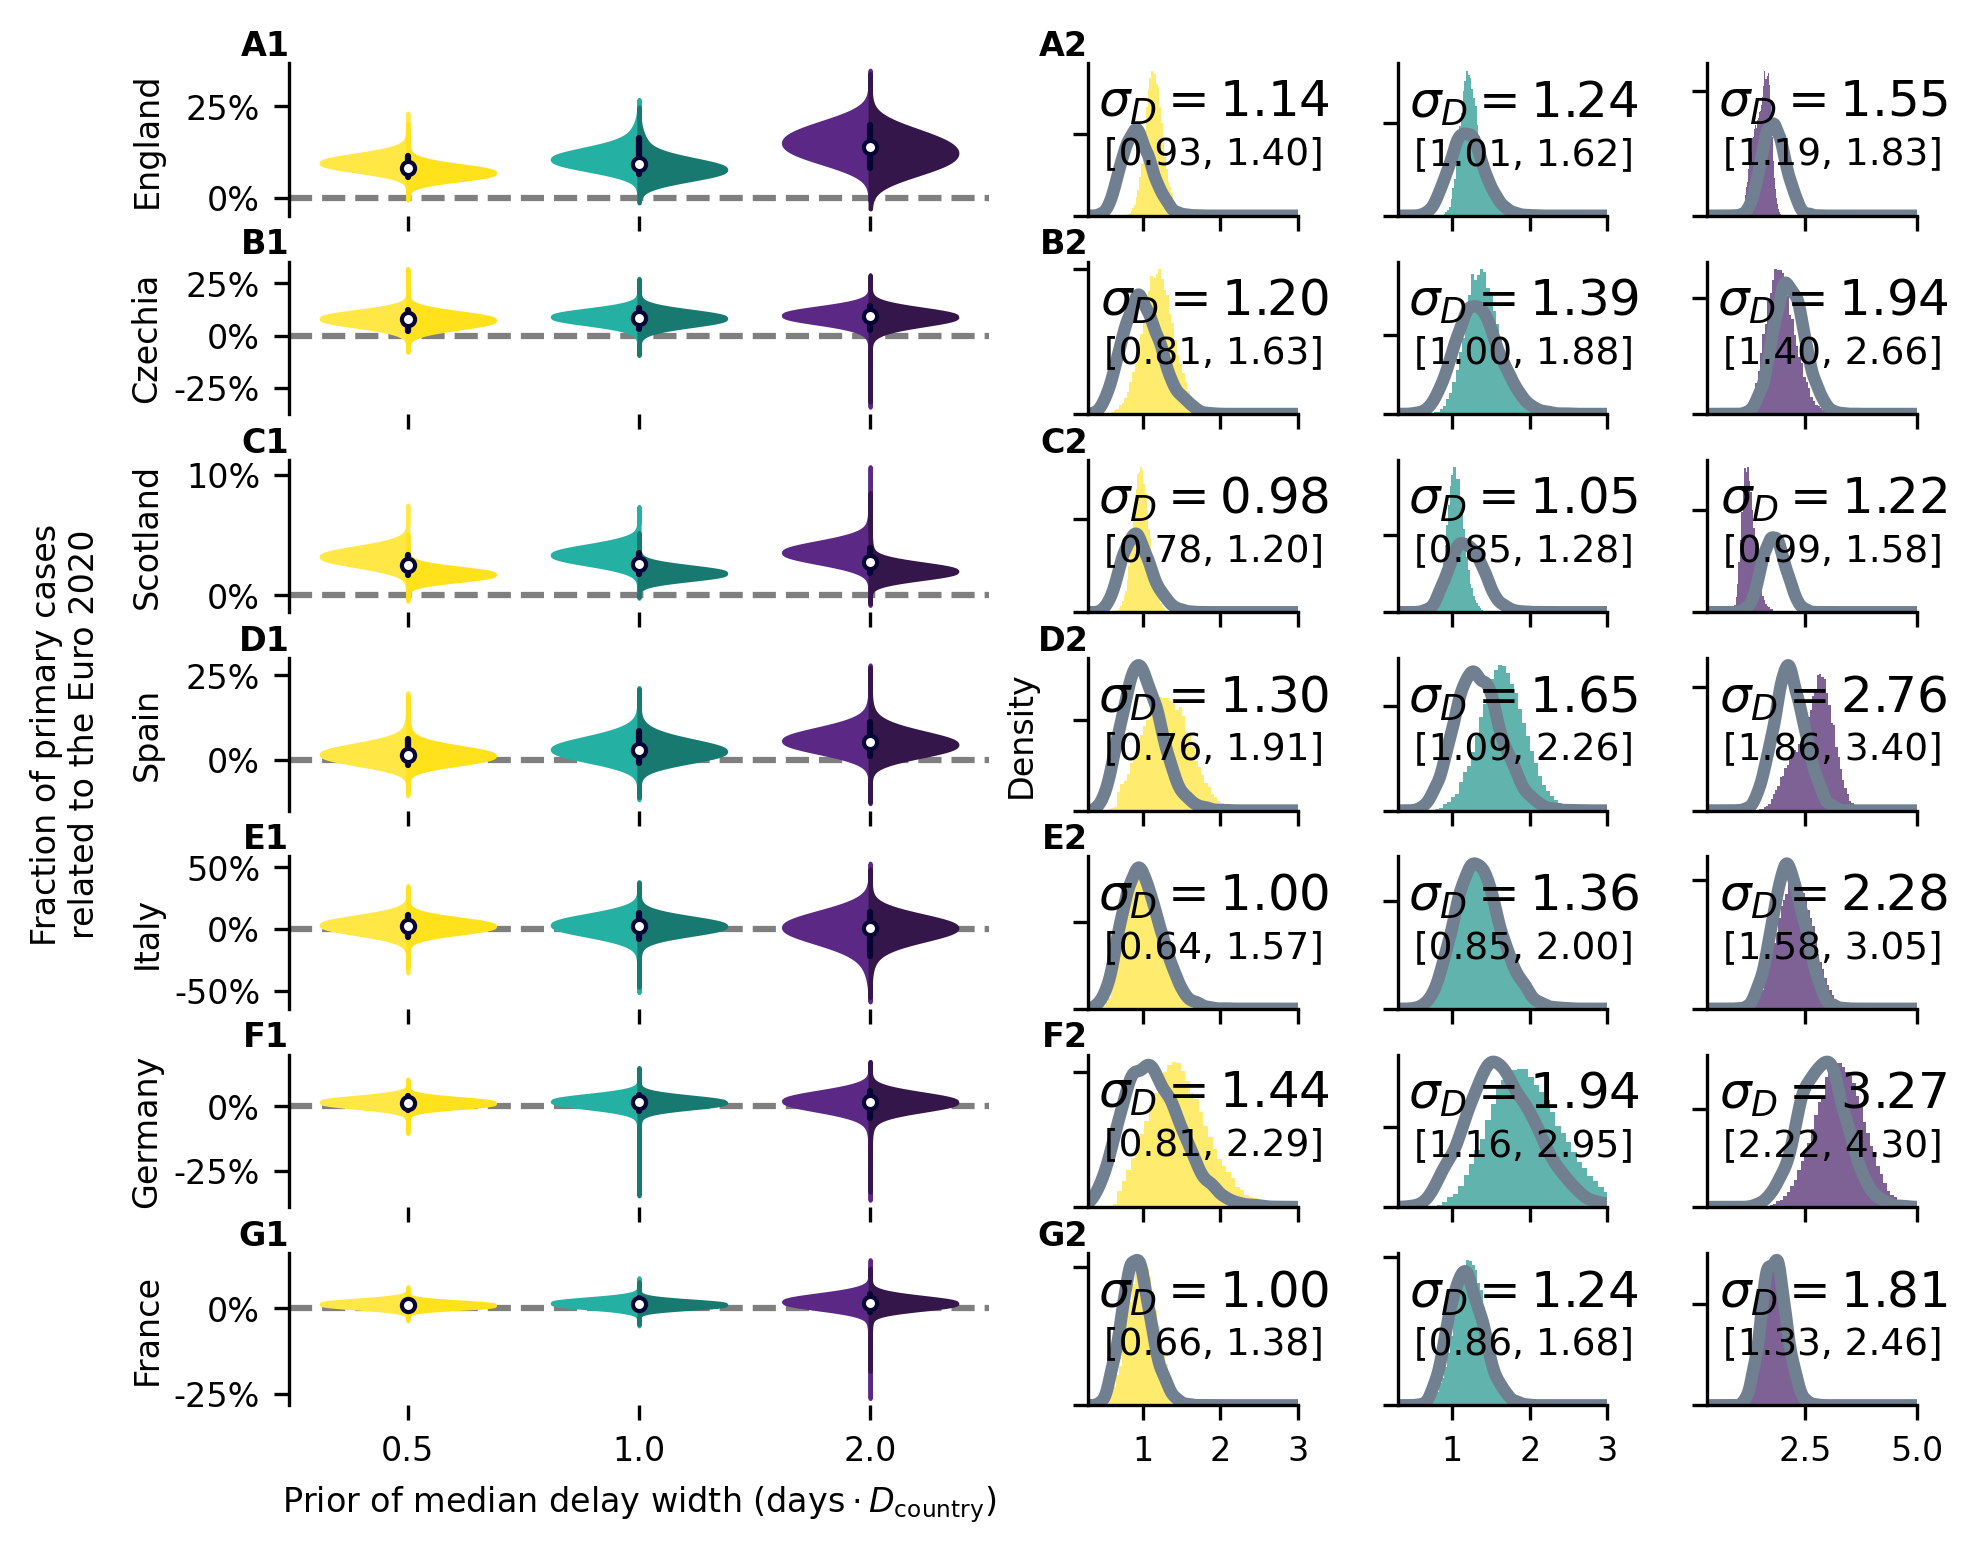

In [37]:
from covid19_soccer.plot.utils import lighten_color
from covid19_soccer.plot.rcParams import *
from matplotlib.colors import to_hex
fig, axes = plt.subplots(len(countries),4,figsize=(7,len(countries)*0.83),gridspec_kw={"width_ratios":[1,0.3,0.3,0.3],"hspace":0.3,"wspace":0.3})

colors_base = ["#ffe530","#1e958a","#481f68"]
l = 0.9
d = 1.1

colors_mf = []
for col in colors_base:
    colors_mf.append(to_hex(lighten_color(col,l)))
    colors_mf.append(to_hex(lighten_color(col,d)))
colors_mf = np.array(colors_mf)

for i, country in enumerate(countries):
    covid19_soccer.plot.other.soccer_related_cases_overview(
        ax=axes[i,0],
        traces=traces[country],
        models=models[country],
        dls=dls[country],
        country_order=[0,1,2],
        colors=colors_mf,
        remove_outliers=True,
        bw=1
        )
    axes[i,0].set_xticklabels(["0.5","1.0","2.0"])
    axes[i,0].set_ylabel(dls[country][0].countries[0])
    axes[i,0].yaxis.set_label_coords(-0.18, 0.5)

    if i != len(countries)-1:
        axes[i,0].set_xticklabels([])

    for j, (trace, model , dl, color,ls) in enumerate(zip(traces[country], models[country], dls[country], colors_base, [(0, (5, 7)),"dashed","-"])):
        
        if j == 2:
            axes[i,j+1].set_xlim(0.3,5)
        else:
            axes[i,j+1].set_xlim(0.3,3)
        rcParams.color_posterior=colors_base[j]
        covid19_soccer.plot.distributions.distribution(
            model,
            trace,
            "delay-width",
            nSamples_prior=5000,
            title="",
            dist_math="\sigma_{D}",
            ax=axes[i,j+1],
        )
        if i != len(countries)-1:
            axes[i,j+1].set_xticklabels([])
    #axes[i,1].set_ylim(0.6,2)
    #axes[i,1].set_yticks([1,1.5])
    #axes[i,1].yaxis.set_label_coords(-0.12, 0.5)
# Array of capital letters
letters = np.array(list("ABCDEFGHIJKLMNOPQRSTUVWXYZ"))

# Add label letters to figure
for i, country in enumerate(countries):
    axes[i,0].text(
        0,
        1.22,
        letters[i]+"1",
        transform=axes[i,0].transAxes,
        fontsize=8,
        fontweight="bold",
        verticalalignment="top",
        ha="right",
    )
    axes[i,1].text(
        0,
        1.22,
        letters[i]+"2",
        transform=axes[i,1].transAxes,
        fontsize=8,
        fontweight="bold",
        verticalalignment="top",
        ha="right",
    )
# set ylims
ylims = {
    "England":[-3,25],
    "Czechia":[-7,25],
    "Italy":[-20,30],
    "Scotland":[0.5,9.5],
    "Spain":[-3,15],
    "Germany":[-9.5,15],
    "France":[-5,8],
}
#for i, country in enumerate(countries):
#    axes[i,0].set_ylim(ylims[country])

# Set overarching y labels
axes[3,0].text(-0.32,0.5,"Fraction of primary cases\nrelated to the Euro 2020",transform=axes[3,0].transAxes,rotation=90,ha="center",va="center",fontsize=8)
axes[3,1].text(-0.32,0.5,"Density",transform=axes[3,1].transAxes,rotation=90,ha="center",va="center",fontsize=8)



axes[-1,0].set_xlabel("Prior of median delay width ($\mathrm{days}\cdot D_\mathrm{country}}/5$)")

plt.show()
fig.savefig(f"{fig_path}/delay_widths.pdf", **save_kwargs)
fig.savefig(f"{fig_path}/delay_widths.png", **save_kwargs)
plt.close(fig=fig)
